In [7]:
from pandas_datareader import data as pdr
import datetime
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [8]:
portfolio = ["SPYG", "SPY", "QQQ", "TQQQ"]
portfolio_ratio = [0.25, 0.25, 0.25, 0.25]
portfolio_seed = 100000
test_years = 40
rebalancing = True
rebalancing_month = [1, 4, 7, 10]
#rebalancing_month = [i for i in range(1, 13)]
start_day = datetime.datetime.now()-datetime.timedelta(days=int(365*test_years))  # 5년치

portfolio_holdings = []
market_index = pdr.get_data_yahoo("^GSPC", start_day)  # S&P 500
for ticker in portfolio:
    portfolio_holdings.append(pdr.get_data_yahoo(ticker, start_day))

In [9]:
# 테스트 기간을 전체 종목 중 최소 기간에 맞춤
def set_period(market_index, portfolio_holdings):
    print("입력 시작 기간 :", market_index.reset_index()["Date"][0])
    min_length = len(market_index)

    for i in range(len(portfolio_holdings)):
        if min_length > len(portfolio_holdings[i]):
            min_length = len(portfolio_holdings[i])

    min_length = min([df.shape[0] for df in portfolio_holdings])
    market_index = market_index[len(market_index)-min_length:]

    portfolio_holdings = [df[len(df)-min_length:] for df in portfolio_holdings]
    print("포트폴리오 시작일 :", market_index.reset_index()["Date"][0])

    return market_index, portfolio_holdings

market_index, portfolio_holdings = set_period(market_index, portfolio_holdings)

입력 시작 기간 : 1982-09-07 00:00:00
포트폴리오 시작일 : 2010-02-11 00:00:00


In [10]:
market_index["recent_high"] = market_index["Adj Close"].cummax()
market_index["dd"] = (1 - market_index["Adj Close"]/market_index["recent_high"]) * 100
market_yield = market_index["Adj Close"][-1]/market_index["Adj Close"][0]

portfolio_df = portfolio_holdings[0].copy()
portfolio_df["seed"] = 0
portfolio_df["rebalancing"] = 0

def simulation(portfolio_holdings, market_index):
    # 주가 변화 시뮬레이션
    rebalanced_month = 0
    portfolio_holdings.append(market_index)

    # 전일 대비 변동률 계산
    portfolio_ratio.append(1)
    for i, df in enumerate(portfolio_holdings):
        df["change"] = df["Adj Close"].pct_change()+1
        df["seed"] = portfolio_seed*portfolio_ratio[i]

    # 주가 변화 계산
    for i in tqdm(range(1, len(market_index))):
        for df in portfolio_holdings:
            df["seed"][i] = df["seed"][i-1]*df["change"][i]

        # 리밸런싱. 연 1회 리밸런싱은 코드 수정해야함
        # 매 달의 1일이 공휴일인 경우도 있으므로 최대 4일까지 고려
        if (df.index[i].month in rebalancing_month) and (df.index[i].day in [1, 2, 3, 4]) and rebalancing:
            # 리밸런싱된 월이 이번달이 아닐 때
            if rebalanced_month != df.index[i].month:
                rebalanced_month = df.index[i].month
                temp_seed = 0
                for df in portfolio_holdings[:-1]:
                    temp_seed += df["seed"][i]*0.9975
                for j, df in enumerate(portfolio_holdings[:-1]):
                    df["seed"][i] = temp_seed*portfolio_ratio[j]
                    portfolio_df["rebalancing"][i] = 1

    return portfolio_holdings[:-1], portfolio_holdings[-1]

def print_analyze(name, df):
    def print_standard_analyze(name, df):
        print(f"종목명 : {name}")
        total_yield = df["seed"][-1]/df["seed"][0]
        print(f"최종금액 : {int(df['seed'][-1])}원")
        print(f"총 수익률 : {round((total_yield-1)*100, 2)}%")
        print(f"연평균 수익률 : {round((total_yield ** (1/test_years)-1) * 100, 2)}%")

        df["recent_high"] = df["seed"].cummax()
        df["dd"] = (1 - df["seed"]/df["recent_high"]) * 100
        print(f"최대 낙폭(MDD) : {round(df['dd'].max(), 2)}%\n")

        return total_yield

    if name != "포트폴리오":
        print_standard_analyze(name, df)
        global portfolio_df
        portfolio_df["seed"] += df["seed"]

    else:
        portfolio_yield = print_standard_analyze("포트폴리오", df)

        print(f"포트폴리오의 최초 금액은 {portfolio_seed}원, 최종 금액은 {int(df['seed'][-1])}원으로 최종 수익률은 {round((portfolio_yield-1)*100, 2)}% 입니다.\n"
              f"같은 기간 동안 시장의 수익률은 {round((market_yield-1)*100, 2)}%로 시장{'을 이겼습니다.' if portfolio_yield>market_yield else '에 졌습니다.'}\n"
              f"최대 낙폭은 {round(df['dd'].max(), 2)}로 같은 기간 시장 최대 낙폭 {round(market_index['dd'].max(), 2)}보다 더 {'높아 위험합니다.' if df['dd'].max() > market_index['dd'].max() else '낮아 안정적입니다.'}")

        print()

In [11]:
portfolio_holdings, market_index = simulation(portfolio_holdings, market_index)

for index, df in enumerate(portfolio_holdings):
    print_analyze(portfolio[index], df)

print_analyze("포트폴리오", portfolio_df)


100%|██████████| 3157/3157 [00:00<00:00, 3165.11it/s]

종목명 : SPYG
최종금액 : 311368원
총 수익률 : 1145.47%
연평균 수익률 : 6.51%
최대 낙폭(MDD) : 39.17%

종목명 : SPY
최종금액 : 303080원
총 수익률 : 1112.32%
연평균 수익률 : 6.44%
최대 낙폭(MDD) : 39.7%

종목명 : QQQ
최종금액 : 311022원
총 수익률 : 1144.09%
연평균 수익률 : 6.51%
최대 낙폭(MDD) : 39.17%

종목명 : TQQQ
최종금액 : 363966원
총 수익률 : 1355.87%
연평균 수익률 : 6.92%
최대 낙폭(MDD) : 72.84%

종목명 : 포트폴리오
최종금액 : 1289437원
총 수익률 : 1189.44%
연평균 수익률 : 6.6%
최대 낙폭(MDD) : 42.64%

포트폴리오의 최초 금액은 100000원, 최종 금액은 1289437원으로 최종 수익률은 1189.44% 입니다.
같은 기간 동안 시장의 수익률은 280.8%로 시장을 이겼습니다.
최대 낙폭은 42.64로 같은 기간 시장 최대 낙폭 33.92보다 더 높아 위험합니다.



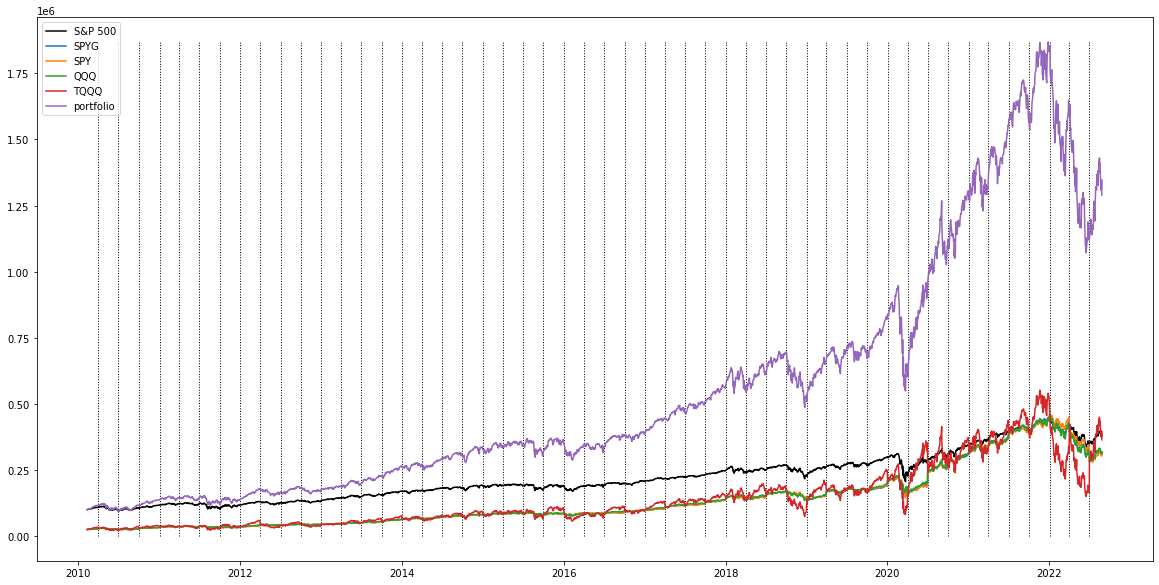

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(market_index["seed"], label="S&P 500", color="black")
for i, df in enumerate(portfolio_holdings):
    plt.plot(df["seed"], label=portfolio[i])

plt.plot(portfolio_df["seed"], label="portfolio")
plt.vlines(portfolio_df[portfolio_df["rebalancing"]==1].index, ymin=0, ymax=portfolio_df["seed"].max(), linewidth=1, linestyles="dotted")
plt.legend()